# General Assembly Capstone: Time Series Forecasting of Texas Electricity Data
----

## <span style="color:Green">03 - Multivariate Time Series Model of Natural Gas Generation with Temperature Data</span>      
----

#### The below notebook conducts univariate time series analysis on the ERCOT natural gas data from 2013-20217. The dataset contains monthly values of natural gas generation and average temperature data across the state of Texas. Guidance on developing the model came from the Facebook Prophet documentation and Krish Naik at the sources below:

https://facebook.github.io/prophet/

https://www.youtube.com/watch?v=VtItg-J6-CI&ab_channel=KrishNaik

#### Raw data sources:

https://www.ncdc.noaa.gov/cdo-web/datatools

http://www.ercot.com/gridinfo/generation

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from fbprophet import Prophet
import plotly.express as px
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# 1. Load and arrange our data### Read in the data

In [2]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')
temp_df = pd.read_csv('../../data/temperature/texas_temp.csv')

In [3]:
df.head()

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
1,2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2,2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
3,2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
4,2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [4]:
temp_df.head()

,Date,Temp
0,1/1/11,45.0
1,2/1/11,48.7
2,3/1/11,61.8
3,4/1/11,70.3
4,5/1/11,74.1


In [5]:
temp_df.dtypes

Date     object
Temp    float64
dtype: object

#### Below, we are selecting only the date, natural gas, and temperature. Natural gas and temperature will be the features being modeled to predict natural gas generation.

In [100]:
df = df[['date', 'NGas']]
df['date']=pd.to_datetime(df['date'])
df = df[df['date'].dt.day == 1]
df.reset_index(inplace=True)
df.drop(columns='index',inplace=True)
df_full = pd.concat([df, temp_df], axis =1)

In [101]:
train_dates = pd.to_datetime(df['date'])
df_full.drop(columns='Date',inplace=True)
df_full.set_index('date', inplace=True)

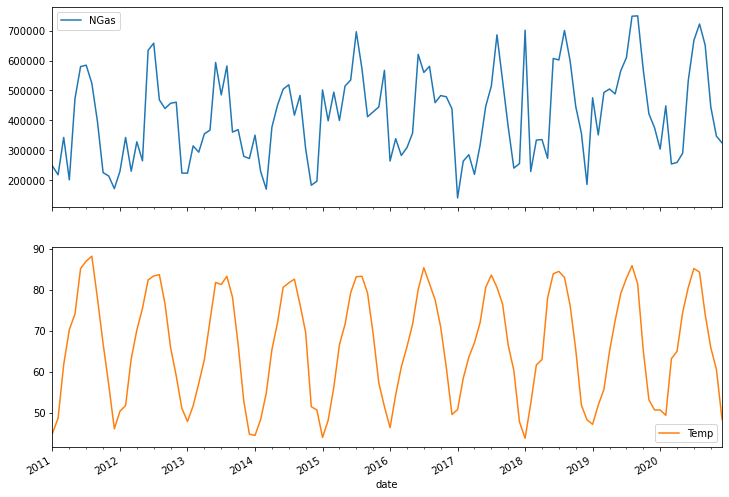

In [102]:
df_full.plot(subplots=True, figsize=(12,9));

#### Facebook Prophet requires specific column names for inputs.

In [24]:
df_final=df_full.reset_index()[['date', 'NGas', 'Temp']].rename({'date':'ds','NGas':'y','Temp':'temp'},axis='columns')

In [25]:
df_final

,ds,y,temp
0,2011-01-01,248086.363990,45.0
1,2011-02-01,218819.159530,48.7
2,2011-03-01,343441.973030,61.8
3,2011-04-01,202053.382820,70.3
4,2011-05-01,472446.061500,74.1
...,...,...,...
115,2020-08-01,721716.604984,84.3
116,2020-09-01,651271.628603,74.0
117,2020-10-01,445206.272739,65.9
118,2020-11-01,347772.901358,60.6


#### Below, we can see relatively good correlation between our target (NGas) and temperature.

In [103]:
df_final[['y', 'temp']].corr()

,y,temp
y,1.000000,0.634777
temp,0.634777,1.000000


# 3. Model the data

#### We will split our dataset into a train and test. We will train on all year from 2011-2019 and will save 2020 for our testing set.

In [104]:
train = df_final[(df_final['ds'] >= '2011-01-01') & (df_final['ds'] < '2020-01-01')]
test = df_final[(df_final['ds'] >= '2020-01-01')]

#### We will istantiate our model with yearly seasonality.

In [106]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [107]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [108]:
m.params

{'k': array([[0.18892982]]),
 'm': array([[0.46117191]]),
 'delta': array([[-3.42894731e-08, -1.24091531e-09, -9.67052068e-10,
         -1.08857285e-08, -2.55469086e-09, -4.78268566e-09,
         -1.27053920e-08, -2.21645625e-08,  4.64875443e-09,
         -4.64716336e-09, -2.70427715e-10,  4.33784307e-10,
          6.72041791e-09, -9.45889541e-09, -4.66005836e-09,
          6.53535610e-09,  5.19882603e-09,  2.65233269e-08,
          3.19873298e-09,  7.69928687e-06, -4.22027366e-10,
          3.07956837e-08, -2.56035356e-08, -4.46440306e-08,
         -7.96191619e-10]]),
 'sigma_obs': array([[0.12878124]]),
 'beta': array([[-3.14549905e-02, -1.79684453e-01,  4.08699555e-03,
          3.55581593e-02,  3.58583347e-03, -2.65772617e-03,
         -6.76516870e-03,  7.70933290e-03,  8.50599195e-03,
          1.38583425e-02, -5.34374130e-03, -8.19452592e-04,
          1.98504706e-03,  2.16943235e-02,  6.63331425e-03,
         -4.73950277e-05, -7.95134532e-03, -1.50878293e-03,
         -2.2500576

#### With out newly fitted model, let's predict 24 months into the future.

In [109]:
future = m.make_future_dataframe(periods=24, freq='MS')
future

,ds
0,2011-01-01
1,2011-02-01
2,2011-03-01
3,2011-04-01
4,2011-05-01
...,...
127,2021-08-01
128,2021-09-01
129,2021-10-01
130,2021-11-01


In [110]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
127,2021-08-01,682400.498186,491768.576988,876792.993213
128,2021-09-01,589791.392797,393594.009768,764709.969230
129,2021-10-01,504581.689105,321559.624349,700566.627556
130,2021-11-01,439355.651487,251825.487844,629403.135789
131,2021-12-01,394591.289460,195938.302576,572336.414796


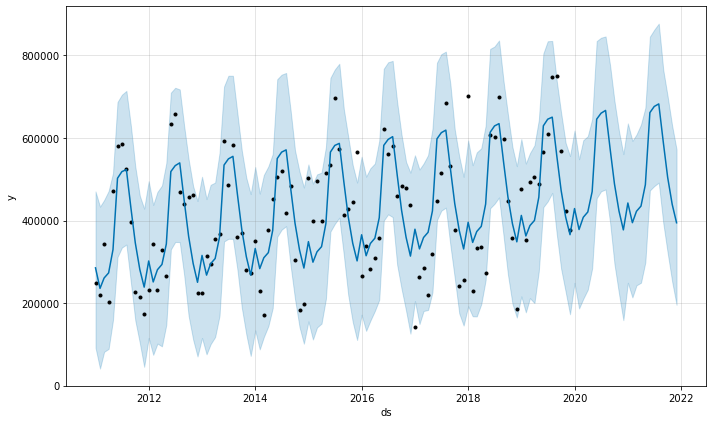

In [111]:
fig1 = m.plot(forecast)

#### Below, we can see the non-stationary aspects of our data that the Prophet model was able to account for in conducting the time series modeling.

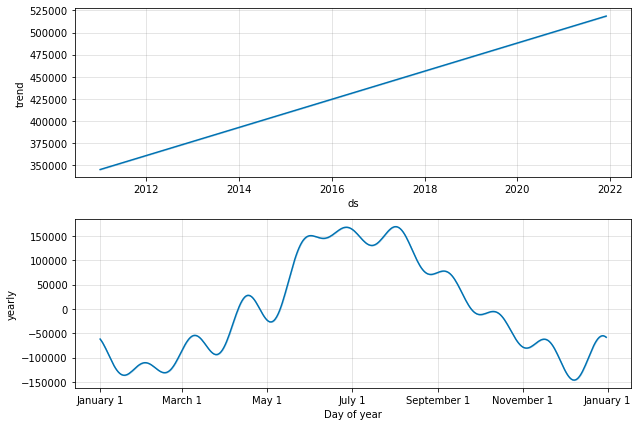

In [112]:
fig2 = m.plot_components(forecast)

# 4. Cross validate

### Cross Validation and Performance Metrics

#### We can measure the forecast error using Prophet's built-in cross validation functionality. This is accomplished by selecting cutoff points in the historical data and fitting the model using data only up to that cutoff point. This is applied to the model below.

In [113]:
cutoffs

DatetimeIndex(['2012-01-01', '2014-01-01', '2016-01-01'], dtype='datetime64[ns]', freq=None)

In [114]:
cutoffs = pd.to_datetime(df_final['ds'].tail(3).values)

In [115]:
cutoffs_1 = cutoffs[:-1]

In [116]:
cutoffs = pd.to_datetime(['2012-01-01', '2014-01-01', '2016-01-01'])
cv_results = cross_validation(model = m, cutoffs=cutoffs, horizon= '365 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


,horizon,mse,rmse,mae,mape,mdape,coverage
0,31 days,1.577276e+11,397149.340027,266940.067722,0.824791,0.425782,0.333333
1,59 days,1.150692e+11,339218.557390,235456.414565,0.886413,0.425782,0.222222
2,60 days,1.820349e+11,426655.457131,314197.259944,1.434523,1.009658,0.333333
3,90 days,1.747639e+11,418047.683015,286402.089508,1.176649,0.236037,0.666667
4,91 days,1.688669e+11,410934.210374,315224.576729,0.958040,0.554770,0.333333
5,120 days,1.662809e+11,407775.583847,290013.559190,0.889314,0.554770,0.333333
6,121 days,4.787773e+10,218809.805044,142739.029822,0.518472,0.105956,0.666667
7,151 days,5.252260e+10,229178.090341,177852.516128,0.587045,0.235577,0.333333
8,152 days,7.345343e+09,85704.976084,71604.189523,0.130001,0.142897,0.666667
9,181 days,5.241952e+09,72401.325408,61450.821675,0.108218,0.142897,1.000000


In [119]:
df_p['mape'].mean()

0.6811206247652423

#### Based on the MAPE of 68%, this model does not model the data well. It's assumed that the sparsity of data was a primary reason for the model's ability to "learn" a sufficent amount to produce viable forecasts.

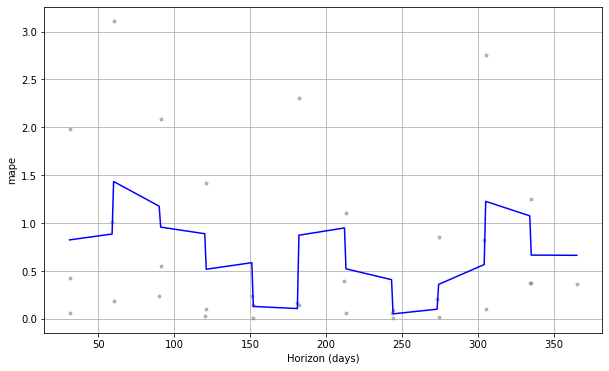

In [117]:
fig3 = plot_cross_validation_metric(cv_results, metric='mape')

# 5. Conclusions

#### The only data available that provided a state-wide average temperature for Texas was in a monthly format. This resulted in a relatively sparse training set that the model was not able to accuractely predict. On the other hand, utilzing more local and robust daily data will likely enable more accurate forecasting. However, it requires a large assumption that the electric grid for the entire state is representative of the average temperature of one city or town.